In [2]:
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter,RecursiveCharacterTextSplitter

from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate

from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.text_splitter import CharacterTextSplitter

import os

os.environ["AZURE_OPENAI_ENDPOINT"]  = "Azure OpenAI EndPoint"
os.environ["AZURE_OPENAI_API_KEY"] = "Azure OpenAI Key"
os.environ["OPENAI_API_TYPE"] = "azure"



#Model
OPENAI_DEPLOYMENT_NAME = "gpt-35-turbo-16k"

#temperature. Default 0.7
temperature=0.7
#file URL
#chunking Option
#prompt


In [3]:
#gpt3.5 turbo
llm = AzureChatOpenAI(
    openai_api_version="2023-09-15-preview",
    azure_deployment=OPENAI_DEPLOYMENT_NAME,
    temperature=temperature,
    deployment_name="OpenAiGpt3turbo"

)
#gpt4 turbo
llmgpt4 = AzureChatOpenAI(
    openai_api_version="2023-09-15-preview",
    azure_deployment="gpt-4-turbo",
    temperature=temperature,
    deployment_name="OpenAiGpt4turbo"
)


### Splitting by Pages or Specific Token size

In [4]:
loader = PyPDFLoader("ING_Call_transcript_1Q2022.pdf")
#load and split will split by chunks with some sliding window.. can be customizable. Just using load will split at page level
pages = loader.load_and_split()

text = ""
for page in pages:
    text += page.page_content
text = text.replace('\t', ' ')
num_tokens = llm.get_num_tokens(text)
print (f"This book has {len(pages)} pages and {num_tokens} tokens in it")


This book has 50 pages and 17301 tokens in it


### Splitting by Sections using Azure document Intelligence

In [5]:
# Using SDK targeting 2023-10-31-preview, make sure your resource is in one of these regions: East US, West US2, West Europe
# pip install azure-ai-documentintelligence==1.0.0b1
# pip install langchain langchain-community azure-ai-documentintelligence

from azure.ai.documentintelligence import DocumentIntelligenceClient

doc_intel_endpoint = "Azure Document Inteligence Endpoint"
doc_intel_key = "Azure Document Inteligence Key"

from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from langchain.text_splitter import MarkdownHeaderTextSplitter
 
# Initiate Azure AI Document Intelligence to load the document. You can either specify file_path or url_path to load the document.
loader = AzureAIDocumentIntelligenceLoader(file_path="ING_Call_transcript_1Q2022.pdf", api_key = doc_intel_key, api_endpoint = doc_intel_endpoint, api_model="prebuilt-layout")
docs = loader.load()
 
# Split the document into chunks base on markdown headers.
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
 
docs_string = docs[0].page_content
sections = text_splitter.split_text(docs_string)
print (f"This book has {len(sections)} sections in it")

#splits

This book has 39 sections in it


## Option 1. Stuff

### --> Generic Summary using GPT3.5

In [15]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate

# Define prompt
prompt_template = """Write a concise summary of the following:
"{text}"
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)


# Define LLM chain
llm_chain = LLMChain(llm=llmgpt4, prompt=prompt)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

print(stuff_chain.run(pages))

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


During the ING 1Q2022 Analyst Meeting on May 6, 2022, CEO Steven van Rijswijk discussed the company's first-quarter results amidst a backdrop of COVID-19 normalization and the challenges posed by the Ukraine invasion, high energy prices, and supply chain disruptions. ING has supported colleagues affected by the conflict and managed its Russia-related exposure while advancing its strategic priorities, including financing the green transition and enhancing digital channels.

ING reported a higher pre-provision profit, resilient net interest income (NII), increased fees, and lower costs. A final cash dividend of 41 cents and an additional EUR 1.25 billion distribution were announced. The NII benefited from a favorable yield curve, mortgage loan growth, and repayment of short-term TLTRO facilities. Costs were managed well despite inflationary pressures, and risk costs were elevated at EUR 987 million, mainly due to actions taken in the Russian portfolio.

The CET1 ratio declined to 14.9%, 

## Option 1. Stuff

### --> Extract Insights(risks/issues/concerns) and Summarize them Using GPT3.5

In [17]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate

# Define prompt
prompt_template = """You are an expert in analyzing Financial earnings transcripts. Following is text from a bank's earnings transcript. Analyze that text to identify potential risks, issues and concerns the bank was facing . Write a concise summary on those potential risks, issues and concerns. 
"{text}"
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

# Define LLM chain
llm_chain = LLMChain(llm=llmgpt4, prompt=prompt)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

print(stuff_chain.run(pages))

The bank, ING, faced several risks, issues, and concerns as highlighted in their 1Q2022 Analyst Meeting Transcript from 6 May 2022. A concise summary of these is as follows:

1. **Geopolitical Risk**: The invasion of Ukraine presented significant challenges, including the safety of colleagues and managing Russia-related exposure.

2. **Financial Risk**: There was an increased risk cost, notably in Stage 2 provisions, due to actions taken concerning their Russian portfolio, which constituted a substantial portion of the risk costs. The bank reduced its Russia-related exposure by almost EUR 1 billion over the past two months.

3. **Capital and Liquidity Risk**: The CET1 ratio declined to 14.9%, mainly driven by Risk-Weighted Assets (RWA) growth primarily from Russia-related exposure and Dutch mortgages. The bank also reported a decline in net customer deposit growth, partially due to outflows in Germany following the introduction of negative rates.

4. **Interest Rate and NII Impact**: T

## Option 2. Map-Reduce - Generic summarization
### --> Generic Summary (Identify main themes). Chunks:Pages, LLM:gpt-35-turbo-16k

In [19]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.text_splitter import CharacterTextSplitter


# Map
map_template = """The following is a set of documents
{docs}
Based on this list of docs, please identify the main themes 
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

# Reduce
reduce_template = """The following is set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main themes. 
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)
#Can split if pages have lot of text
'''textSplitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=0)
docs = textSplitter.split_documents(pages)'''

print(map_reduce_chain.run(pages))

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


The main themes discussed in the 1Q2022 Analyst Meeting Transcript of ING Group revolve around financial performance, risk management, strategic priorities, capital optimization, shareholder value, analyst inquiries, net interest income (NII), risk management and exposure, capital management and returns, fee growth and partnerships, cost management and control, and economic and market conditions. These themes encompass discussions regarding strong financial results, higher pre-provision profit, resilient NII, measures taken to manage risks and reduce exposure, ING's strategic priorities in financing the green transition and improving digital channels, capital optimization and its impact on the CET1 ratio, ING's commitment to delivering value to shareholders through dividends and attractive total returns, analyst questions on potential risks, provisions, and NII tailwinds, NII and its impact on financial performance, risk management strategies and exposure management, capital management

## Option 2. Map-Reduce - Generic summarization
### --> Generic Summary (Identify main themes). Chunks:Sections, LLM:gpt-35-turbo-16k

In [20]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.text_splitter import CharacterTextSplitter


# Map
map_template = """The following is a set of documents
{docs}
Based on this list of docs, please identify the main themes 
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

# Reduce
reduce_template = """The following is set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main themes. 
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)
#Can split if pages have lot of text
'''textSplitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=0)
docs = textSplitter.split_documents(pages)'''

print(map_reduce_chain.run(sections))

The main themes identified in the provided documents can be consolidated into the following summary:

The documents provide insights into ING Group's strong financial performance, with a focus on pre-provision profit, net interest income, fees, and expenses. The bank emphasizes its commitment to supporting the green transition and improving the customer experience through digital capabilities. Loan growth and deposits, strong fee growth, and cost focus are also highlighted. The bank addresses elevated risk costs, particularly related to Russia, but expresses confidence in its risk management framework. The CET1 ratio and risk-weighted assets are discussed, along with external challenges such as the invasion of Ukraine and disrupted supply chains. The bank notes that Covid circumstances are normalizing. Capital adequacy, profitability, and cost optimization are key areas of focus, as well as mitigating risks associated with Russian exposure. The impact of interest rate dynamics on net i

## Option 2. Map-Reduce - Custom summarization
### --> Extract Insights(risks/issues/concerns). Chunks:Pages, LLM:gpt-35-turbo-16k

In [21]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.text_splitter import CharacterTextSplitter


# Map
map_template = """The following is a set of text chunks from an earnings transcript:
{docs}
Based on this list of chunks, please analyze the text to identify potential risks, issues and concerns the bank was facing
For each identified risk, provide a concise description or explanation in a sentence or two, followed by formatting it into a bullet-point list
"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

# Reduce
reduce_template = """The following is set of potential risks, issues and concerns identified from a bank's earnings transcript:
{docs}
Please take these and provide consolidated summary of the risks identified in a bullet-point list with one or two sentences for each point. Summary should have title and each bullet point should have short title.
"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

#Can split if pages have lot of text
'''textSplitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=0)
docs = textSplitter.split_documents(pages)'''

print(map_reduce_chain.run(pages))

Summary of Potential Risks Identified from Bank's Earnings Transcript:

Title: General Risks and Concerns
- Lack of clarity and organization in transcript's formatting and presentation.
- Incomplete information and missing context.
- Uncertainty and potential risk in forward-looking statements.
- Impact of geopolitical risks and high energy prices.
- Disruption to supply chains.
- Risk management of Russia-related exposure.
- Historical liability pressure turning into a tailwind.

Title: Increasing Central Bank Rates and Rising Interest Rates
- Potential impact on lending margins from increasing Central Bank rates.
- Potential decrease in prepayment penalty income.
- Uncertainty regarding yield curve development and its impact on Net Interest Income (NII) growth.

Title: Fee Growth and Cost Management
- Ambition to maintain annual growth in fees.
- Challenges in cost management amidst inflationary pressure.

Title: Transition to Green and Digitalization
- Risks associated with transiti

## Option 2. Map-Reduce - Custom Summarization
### --> Extract Insights(risks/issues/concerns). Chunks:Sections, LLM:gpt-35-turbo-16k

In [22]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.text_splitter import CharacterTextSplitter


# Map
map_template = """The following is a set of text chunks from an earnings transcript:
{docs}
Based on this list of chunks, please analyze the text to identify potential risks, issues and concerns the bank was facing
For each identified risk, provide a concise description or explanation in a sentence or two, followed by formatting it into a bullet-point list
"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

# Reduce
reduce_template = """The following is set of potential risks, issues and concerns identified from a bank's earnings transcript:
{docs}
Please take these and provide consolidated summary of the risks identified in a bullet-point list with one or two sentences for each point. Summary should have title and each bullet point should have short title.
"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

#Can split if pages have lot of text
'''textSplitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=0)
docs = textSplitter.split_documents(pages)'''

print(map_reduce_chain.run(sections))

Title: Overall Risks and Concerns
- Financial performance expectations: Risk of not meeting financial performance expectations.
- Regulatory compliance: Concerns about compliance with regulatory requirements.
- Market volatility: Awareness of market volatility and its impact on the business.
- Securities offering: Concerns about legal and regulatory compliance in securities transactions.
- Financial performance: Focus on maintaining or improving financial results.
- Risk management: Focus on managing and mitigating risks within the bank.
- Investor confidence: Emphasis on maintaining or enhancing investor confidence.

Title: Geopolitical and Macroeconomic Risks
- Ukraine invasion: Adverse impact on operations and exposure to Russia-related assets.
- Energy prices and supply chain disruptions: Potential impact on customers and economy, leading to higher loan default rates.
- Elevated risk costs and credit risk: Potential credit risk and increased provisions, especially related to Russia

## Option 3. Refine - Generic Summarization
### --> Chunks:Sections, LLM:gpt-35-turbo-16k


In [24]:
prompt_template = """Write a concise summary of the following:
{text}
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

refine_template = (
    "Your job is to produce a final summary\n"
    "We have provided an existing summary up to a certain point: {existing_answer}\n"
    "We have the opportunity to refine the existing summary"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "Given the new context, refine the original summary"
    "If the context isn't useful, return the original summary."
)


refine_prompt = PromptTemplate.from_template(refine_template)
chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=prompt,
    refine_prompt=refine_prompt,
    return_intermediate_steps=True,
    input_key="input_documents",
    output_key="output_text",
)
result = chain({"input_documents": sections}, return_only_outputs=True)
print(result["output_text"])

ING reported a net profit of €429 million for Q1 2022, driven by loan growth in the retail segment and continued fee income growth. The company acknowledged challenges posed by the invasion of Ukraine, high energy prices, and disrupted supply chains. ING plans to pay a final cash dividend of €0.41 per share and distribute an additional €1.25 billion to optimize its capital structure. The bank aims to maintain an attractive total return through growth, cost and capital optimization, and achieving a cost-income ratio of 50-52%. ING feels confident in its current provisioning and capital adequacy regarding its Russian exposure, which is covered by €2.5 billion within the CET1 ratio. The CEO mentioned that the bank currently incurs €300 million annually due to negative interest rate charging and expects this amount to be lost once the ECB rate hikes from minus 50 to zero. Loan growth in the Wholesale segment mainly comes from syndicated markets, while real estate finance has decreased. ING

In [25]:
print("\n\n".join(result["intermediate_steps"][:3]))

ING reported a net profit of €429 million for the first quarter of 2022. The CEO, Steven van Rijswijk, discussed the company's financial performance and future developments during a conference call. The company emphasized that forward-looking statements should be taken with caution and that actual results may differ from projections. The CEO was joined by the CFO and CRO during the call.

ING reported a net profit of €429 million for the first quarter of 2022. The CEO, Steven van Rijswijk, discussed the company's financial performance and future developments during a conference call. The company emphasized that forward-looking statements should be taken with caution and that actual results may differ from projections. The CEO was joined by the CFO and CRO during the call. The pre-provision profit was strong, supported by resilient net interest income (NII), strong fees, and lower expenses. The company highlighted its support for the green transition through renewable energy financing a

## Option 3: Refine - Custom summarization
### --> Extract Insights(risks/issues/concerns). Chunks:Sections, LLM:gpt-35-turbo-16k

In [31]:
prompt_template = """You are an AI with expertise in analyzing financial earnings transcripts to identify potential risks, issues, and concerns that could impact a company's performance. 
Following is text from a Financial Company's earnings transcript. 
{text}
Analyze the above text to identify potential risks, issues and concerns 
the company was facing . Write a concise summary on those potential risks, issues and concerns
"""
prompt = PromptTemplate.from_template(prompt_template)



refine_template = """You are an AI with expertise in analyzing financial earnings transcripts to identify potential risks, issues, and concerns that could impact a company's performance. 

Existing Summary of Potential Risks, Issues, and Concerns:
{existing_answer}

Please review the following new text from a recent financial earnings transcript:
{text}

Based on your analysis, refine the existing summary with any new potential risks, issues, and concerns identified in the new text. Ensure to:
- Clearly distinguish between previously identified risks and any new insights.
- Provide a concise explanation for each new risk, issue, or concern identified.
- If no new risks or issues are found, return the existing summary. 

Your goal is to ensure that the summary of identified risks, issues, and concerns is current and reflects any new information presented in the latest earnings transcript.
"""

refine_prompt = PromptTemplate.from_template(refine_template)
chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=prompt,
    refine_prompt=refine_prompt,
    return_intermediate_steps=True,
    input_key="input_documents",
    output_key="output_text",
)
result = chain({"input_documents": sections}, return_only_outputs=True)
print(result["output_text"])

Updated Summary of Potential Risks, Issues, and Concerns:
1. Elevated risk cost impacting ROE: The mention of elevated risk costs impacting ROE suggests a potential increase in credit losses or provisions. This can arise from factors such as deteriorating credit quality, economic downturn, or higher default rates. Elevated risk costs can reduce ING's profitability and adversely impact its financial performance.

2. Impact of invasion of Ukraine: The invasion of Ukraine poses new challenges for ING. Geopolitical tensions and potential economic impacts from the invasion can result in increased credit losses, market volatility, regulatory changes, and geopolitical uncertainties. These risks can negatively affect ING's operations and financial performance.

3. Stagflation concerns: The mention of stagflation raises concerns about lower-than-expected growth and higher inflation. While ING benefits from a strong risk management framework and low-risk book structure, managing this scenario ma

In [33]:
print("\n\n".join(result["intermediate_steps"]))

From the provided text, there are a few potential risks, issues, and concerns that can be identified for ING:

1. Forward-looking statements: The mention of forward-looking statements indicates that there is uncertainty regarding the future developments and financial performance of the company. Actual results may differ from the projections, which could impact ING's performance.

2. Regulatory compliance: The reference to public filings, including the most recent Annual Report on Form 20-F filed with the United States Securities and Exchange Commission, suggests that regulatory compliance is an important concern for ING. Non-compliance with regulations could result in penalties or reputational damage.

3. Economic conditions: The transcript does not explicitly mention economic conditions, but the overall tone of caution and the need to discuss factors that may cause actual results to differ from projections indicates that ING may be concerned about the impact of economic conditions on 

## Option 4. Chain of Density
### --> Stuff Approach LLM:gpt-4-turbo

In [34]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate


# While we are using the standard prompt by langchain, you can modify the prompt to suit your needs
promptTemplate = """Earning call Transcript:
  
        {text}

        You will generate increasingly concise, entity-dense summaries of the above Earning call Transcript.

        Repeat the following 2 steps 2 times.

        Step 1. Identify 1-3 informative Entities (";" delimited) from the text which are missing from the previously generated summary.

        Step 2. Write a new, denser summary of identical length which covers every entity and detail from the previous summary plus the Missing Entities.

        A Missing Entity is:

        Relevant: to the main story.
        Specific: descriptive yet concise (5 words or fewer).
        Novel: not in the previous summary.
        Faithful: present in the content piece.
        Anywhere: located anywhere in the Article.

        Guidelines:

        The first summary should be long (4-5 sentences, ~250 words) yet highly non-specific, containing little information beyond the entities marked as missing. Use overly verbose language and fillers (e.g., "this article discusses") to reach ~250 words.
        Make every word count: re-write the previous summary to improve flow and make space for additional entities.
        Make space with fusion, compression, and removal of uninformative phrases like "the article discusses".
        The summaries should become highly dense and concise yet self-contained, e.g., easily understood without the Article.
        Missing entities can appear anywhere in the new summary.
        Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
        Remember, use the exact same number of words for each summary.
        Answer in JSON. The JSON should be a list (length 3) of dictionaries whose keys are "Missing_Entities" and "Denser_Summary"."""
prompt = PromptTemplate.from_template(promptTemplate)

llm_chain = LLMChain(llm=llmgpt4, prompt=prompt)

stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

print(stuff_chain.run(sections))


```json
[
    {
        "Missing_Entities": "Steven van Rijswijk, CEO; CET1 ratio; ECB rate hikes; Wholesale Banking loan growth; mortgage book origination",
        "Denser_Summary": "In this extensive and thorough overview of ING's financial performance for the first quarter of 2022, we are presented with a detailed account of the company's earnings and strategic initiatives, as articulated by CEO Steven van Rijswijk. The narrative delves into the intricacies of ING's resilience in the face of macroeconomic challenges, outlining the financial institution's commitment to maintaining a robust CET1 ratio amidst regulatory changes and market volatility. Furthermore, the discourse touches upon the implications of potential ECB rate hikes on ING's net interest income trajectory, as well as the company's focus on sustaining loan growth within its Wholesale Banking segment. Additionally, there is a consideration of mortgage book origination trends, which are influenced by the broader economi

## Best Representation Vectors 

In [20]:
from langchain.document_loaders import PyPDFLoader
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

# Load the book
loader = PyPDFLoader("ING_Call_transcript_1Q2022.pdf")
pages = loader.load()

# Cut out the open and closing parts
#pages = pages[26:277]

# Combine the pages, and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=1000, chunk_overlap=300)
docs = text_splitter.create_documents([text])

num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 106 documents


In [21]:
from langchain.embeddings import AzureOpenAIEmbeddings
embedder = AzureOpenAIEmbeddings(deployment="text-embedding-ada-002", chunk_size=1) 
#embedder.embed_query("THis is Sreedhar")
vectors= embedder.embed_documents([x.page_content for x in docs])

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.azure_openai.AzureOpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import AzureOpenAIEmbeddings`.
  warn_deprecated(


Now let's cluster our embeddings. There are a ton of clustering algorithms you can chose from. Please try a few out to see what works best for you!

In [22]:
# Assuming 'embeddings' is a list or array of 1536-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 11

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Here are the clusters that were found. It's interesting to see the progression of clusters throughout the book. This is expected because as the plot changes you'd expect different clusters to emerge due to different semantic meaning

In [23]:
kmeans.labels_

array([ 1,  1,  1,  4,  4,  7,  4,  4,  4,  9,  5,  5,  5,  5,  4,  4,  6,
        6,  6,  9,  9,  9,  4,  3,  7,  7,  7,  2,  2,  9,  9,  7,  3,  3,
        3,  3,  4,  0,  0,  4, 10, 10,  4,  3, 10, 10, 10, 10,  0,  3,  7,
        7,  8, 10, 10,  0,  9,  3,  2,  1,  8,  8,  8,  8,  8,  8,  9,  3,
        0,  3,  3,  0,  0,  0,  8,  8,  4,  0, 10, 10,  4,  4,  7,  3,  7,
        3,  0,  3,  3,  1,  3,  3,  3,  3,  3,  1,  0,  0,  8,  8, 10,  3,
        3,  3,  1,  1], dtype=int32)

This is sweet, but whenever you have a clustering exercise, it's hard *not* to graph them. Make sure you add colors.

We also need to do dimensionality reduction to reduce the vectors from 1536 dimensions to 2 (this is sloppy data science but we are working towards the 80% solution)

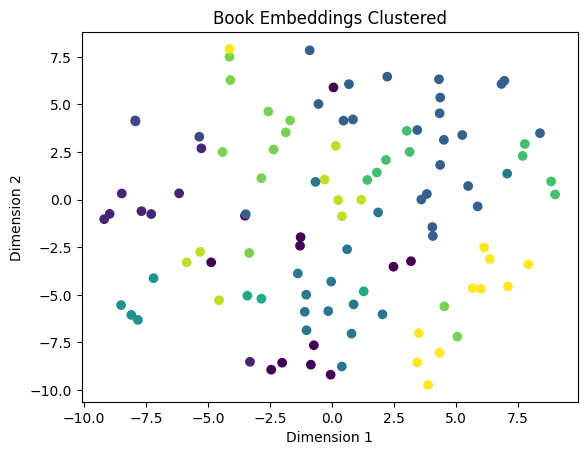

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

vectors_array = np.array(vectors)


# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(vectors_array)

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

Awesome, not perfect, but pretty good directionally. Now we need to get the vectors which are closest to the cluster centroids (the center).

The function below is a quick way to do that (w/ help from ChatGPT)

In [25]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

Now sort them (so the chunks are processed in order)

In [26]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 4, 12, 17, 20, 27, 31, 41, 65, 92, 97]

It's intersting to see which chunks pop up at most descriptive. How does your distribution look?

Let's create our custom prompts. I'm going to use gpt4 (which has a bigger token limit) for the combine step so I'm asking for long summaries in the map step to reduce the information loss.

In [27]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [28]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)

Then go get your docs which the top vectors represented.

In [29]:
selected_docs = [docs[doc] for doc in selected_indices]

Let's loop through our selected docs and get a good summary for each chunk. We'll store the summary in a list.

In [30]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):
    
    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])
    
    # Append that summary to your list
    summary_list.append(chunk_summary)
    
    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Summary #0 (chunk #0) - Preview: The passage is the transcript of the 1Q2022 analyst meeting for ING Group. Patricia Krooshof-Naughten, the operator, welcomes the participants to the conference call. She mentions that the comments made during the call may include forward-looking sta 

Summary #1 (chunk #4) - Preview: In this passage, it is mentioned that there is an additional distribution of EUR 1.25 billion announced. The author also states that the current yield curve is causing a shift in liability pressure, turning it into a tailwind. 

The passage goes on t 

Summary #2 (chunk #12) - Preview: The passage discusses the expanded digital capabilities for customers and how it helps improve efficiency and customer experience. The company invests in digitalizing processes to achieve a higher first-time right and shorter time-to-yes. An example  

Summary #3 (chunk #17) - Preview: In this passage, it is stated that the fee income for the year has increased by 9%, with growth seen in bot

Great, now that we have our list of summaries, let's get a summary of the summaries

In [31]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 2278 tokens


In [33]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

reduce_chain = load_summarize_chain(llm=llmgpt4,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
#                              verbose=True # Set this to true if you want to see the inner workings
                                   )

output = reduce_chain.run([summaries])
print (output)

In the book, which appears to be a detailed transcript of ING Group's first quarter (1Q2022) analyst meeting, various aspects of the company's financial performance, future outlook, strategic decisions, and specific challenges are discussed. The meeting begins with Patricia Krooshof-Naughten, the operator, setting the tone by cautioning that forward-looking statements may not fully materialize and actual results could differ.

The financial highlights from the discussions indicate that ING Group announced an additional EUR 1.25 billion distribution to shareholders, reflecting a positive financial stance. The yield curve's evolution is turning liability pressures into tailwinds, boding well for the company's future interest income. The mortgage loan sector experienced growth, and there was a reduction in short-term TLTRO facilities in Wholesale banking. Fee income showed a robust 9% year-on-year increase, driven by strong performance in daily banking and lending, as well as investment p